In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from tsmoothie.smoother import LowessSmoother
import numpy as np

In [ ]:
# Outlier removal function returning a cleaned Series without modifying the original DataFrame

def rolling_med_clean(df, col_name, window, quantile):
    """
    Removes outliers from df[col_name] by:
      1) Computing rolling median over specified window
      2) Calculating absolute deviations from that median
      3) Masking points where deviation >= given quantile threshold
      4) Imputing masked points by averaging nearest valid neighbors

    Does NOT modify the original df. Instead returns a new pandas.Series.

    Parameters
    ----------
    df : pandas.DataFrame
        Source DataFrame containing the column to clean.
    col_name : str
        Name of the numeric column to process.
    window : int
        Rolling window size for median calculation.
    quantile : float
        Quantile (0 < quantile < 1) to determine outlier cutoff on absolute deviations.

    Returns
    -------
    pandas.Series
        A new Series of the same length as df with the same name as col_name.
    """
    # 1) Rolling median
    med_vals = df[col_name].rolling(window=window, center=True, min_periods=1).median()

    # 2) Absolute deviation
    med_dif = (df[col_name] - med_vals).abs()

    # 3) Mask outliers beyond the quantile
    threshold = med_dif.quantile(quantile)
    mask = med_dif >= threshold

    # 4) Build cleaned Series, initializing with original values
    cleaned = df[col_name].copy()
    valid_idx = cleaned.index[~mask]

    # Impute each outlier by nearest valid neighbors
    for idx in cleaned.index[mask]:
        prev_valid = valid_idx[valid_idx < idx]
        next_valid = valid_idx[valid_idx > idx]
        if len(prev_valid) and len(next_valid):
            cleaned.at[idx] = (
                df.at[prev_valid.max(), col_name] + 
                df.at[next_valid.min(), col_name]
            ) / 2
        elif len(prev_valid):
            cleaned.at[idx] = df.at[prev_valid.max(), col_name]
        elif len(next_valid):
            cleaned.at[idx] = df.at[next_valid.min(), col_name]

    # Rename the Series to indicate outliers removed
    cleaned.name = f"{col_name}"
    return cleaned

In [ ]:
def second_diff_clean(df: pd.DataFrame, col: str, quantile: float) -> pd.Series:
    """
    Clean outliers in df[col] based on centered second differences.

    Steps:
      1. Compute first differences d1 and d2.
      2. Compute centered second difference sec = y.shift(-1) - 2*y + y.shift(1).
      3. Where slopes change sign (d1 * d2 < 0), sec_diff = abs(sec), else 0.
      4. Determine threshold = sec_diff.quantile(quantile).
      5. Mask points where sec_diff > threshold.
      6. Initialize cleaned series with original values.
      7. Impute each masked outlier using nearest valid neighbors:
         - If both previous and next valid exist, impute their mean.
         - Otherwise, use whichever neighbor exists.
      8. Return the cleaned series.
    """
    y = df[col]
    # First differences
    d1 = y - y.shift(1)
    d2 = y.shift(-1) - y
    # Centered second difference
    sec = y.shift(-1) - 2 * y + y.shift(1)

    # Absolute second difference when slope changes sign, else 0
    sec_diff = pd.Series(
        np.where(d1 * d2 <= 0, sec.abs(), 0),
        index=df.index
    )

    # Compute quantile threshold and mask outliers
    thresh = sec_diff.quantile(quantile)
    mask = sec_diff > thresh

    # Initialize cleaned series
    cleaned = y.copy()
    valid_idx = cleaned.index[~mask]

    # Impute each outlier by nearest valid neighbors
    for idx in cleaned.index[mask]:
        prev_valid = valid_idx[valid_idx < idx]
        next_valid = valid_idx[valid_idx > idx]
        if len(prev_valid) and len(next_valid):
            cleaned.at[idx] = (
                df.at[prev_valid.max(), col] + df.at[next_valid.min(), col]
            ) / 2
        elif len(prev_valid):
            cleaned.at[idx] = df.at[prev_valid.max(), col]
        elif len(next_valid):
            cleaned.at[idx] = df.at[next_valid.min(), col]
    
    # Ensure the series has the original name
    cleaned.name = col
    return cleaned

In [ ]:
column_filter = ['Date', 'Time', 'EFG Air Flow Rate lb/hr', 'Primary O2 Flow Rate lb/hr',
                    'EFG System Pressure psi',
                    'Slurry Flow Rate lb/hr',
                    'EFG:EFG_Oxygen_Pressure_1.Value',
                    'EFG:EFG_Oxygen_Pressure_2.Value',
                     'Analyzer 2 CO2 %',
                     'Analyzer 3 O2 %', 
                    'Analyzer 3 CO2%',
                     'ABB CH4',
                    'ABB CO',
                    'ABB CO2',
                    'ABB O2',
                    'GB O2%',
                    'GB CO2%',
                    'GB CO%',
                    'GB CH4%',
                    'GB H2%',
                    'GB C2H4%',
                    'GB C2H2%',
                    'GB LHV [MJ/Nm3]',
                    'EFG:B_TC_1_Shallow.Value',
                    'EFG:B_TC_4_Shallow.Value']

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
rd241203 = pd.read_csv("Gasifier Data Sets/RD241203.csv")
rd241205 = pd.read_csv("Gasifier Data Sets/RD241205.csv")
rd250122 = pd.read_csv("Gasifier Data Sets/RD250122.csv")

In [6]:
dfs = [rd241203, rd241205, rd250122]
for df in dfs:
    if 'Moyno Flow Rate lb/hr' in df.columns:
        df.rename(columns={'Moyno Flow Rate lb/hr': 'Slurry Flow Rate lb/hr'}, inplace=True)

In [7]:
filtered_dfs = [df[column_filter] for df in dfs]

In [ ]:
# List to hold cleaned DataFrames
cleaned_dfs_list = []

for df in filtered_dfs:

    # 1st iteration - fix outliers with rolling median method
    
    # Determine columns to clean (exclude Date and Time)
    cols_to_clean = [col for col in df.columns if col not in ['Date', 'Time']]
    
    # Initialize temp DF 
    temp_df = pd.DataFrame()
    # Apply fix_outliers for each column and append cleaned Series
    for col in cols_to_clean:
        temp_df[col] = rolling_med_clean(df, col, 7, 0.895)

    # Initialize clean DataFrame with Date and Time
    cleaned_df = df[['Date', 'Time']].copy()

    # 2nd iteration - fix outliers with second diff method
    for col in temp_df.columns:
        cleaned_df[col] = second_diff_clean(temp_df, col, 0.895)
    
    # Append to list
    cleaned_dfs_list.append(cleaned_df)


In [ ]:
# Assuming filtered_dfs is your list of dataframes
smoothed_dfs = []

# Loop through each dataframe in the clean list
for df in cleaned_dfs_list:
    # Create a copy to store smoothed results
    df_smoothed = df.copy()
    
    # Iterate over columns except the first two ("Date" and "Time")
    for col in df.columns[2:]:
        # Initialize the LowessSmoother with a chosen fraction (adjust as needed)
        smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
        
        # Smooth the data for the current column
        smoother.smooth(df[col].values)
        smoothed_series = smoother.smooth_data[0]
        
        # Replace the column data in the copy with the smoothed data
        df_smoothed[col] = smoothed_series
        
    # Append the smoothed dataframe to the list
    smoothed_dfs.append(df_smoothed)

In [9]:
def plot_all_fields(df, title):
    '''
    Plots each non-time column in a compact 3-column grid of subplots vs. the 'Datetime' column.
    Subplot titles have extra space, x-labels are hidden, and y-ticks use smaller font.
    '''
    time_column = 'Time'
    fields = ['EFG Air Flow Rate lb/hr', 'Primary O2 Flow Rate lb/hr',
                    'EFG System Pressure psi',
                    'Slurry Flow Rate lb/hr',
                    'EFG:EFG_Oxygen_Pressure_1.Value',
                    'EFG:EFG_Oxygen_Pressure_2.Value',
                     'Analyzer 2 CO2 %',
                     'Analyzer 3 O2 %', 
                    'Analyzer 3 CO2%',
                     'ABB CH4',
                    'ABB CO',
                    'ABB CO2',
                    'ABB O2',
                    'GB O2%',
                    'GB CO2%',
                    'GB CO%',
                    'GB CH4%',
                    'GB H2%',
                    'GB C2H4%',
                    'GB C2H2%',
                    'GB LHV [MJ/Nm3]',
                    'EFG:B_TC_1_Shallow.Value',
                    'EFG:B_TC_4_Shallow.Value']
    num_fields = len(fields)

    ncols = 5
    nrows = math.ceil(num_fields / ncols)
    height_per_row = 1  # very compact

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(15, height_per_row * nrows),
        sharex=False
    )

    axes = axes.flatten()

    for i, field in enumerate(fields):
        ax = axes[i]
        ax.plot(df[time_column], df[field])
        ax.set_title(field, fontsize=8, pad=8)  # pad=8 adds vertical space above plot
        ax.tick_params(labelbottom=False, labelsize=7)  # remove x labels, shrink y ticks

    # Hide unused axes
    for j in range(len(fields), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.subplots_adjust(hspace=0.75, wspace=0.4)  # More vertical space for titles
    plt.show()


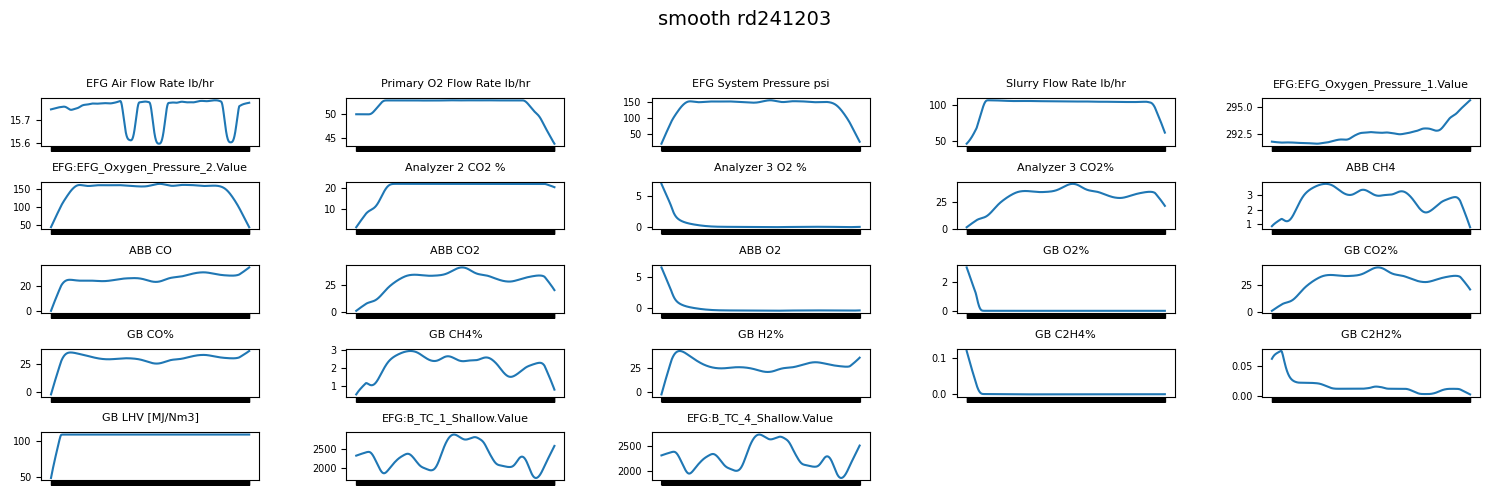

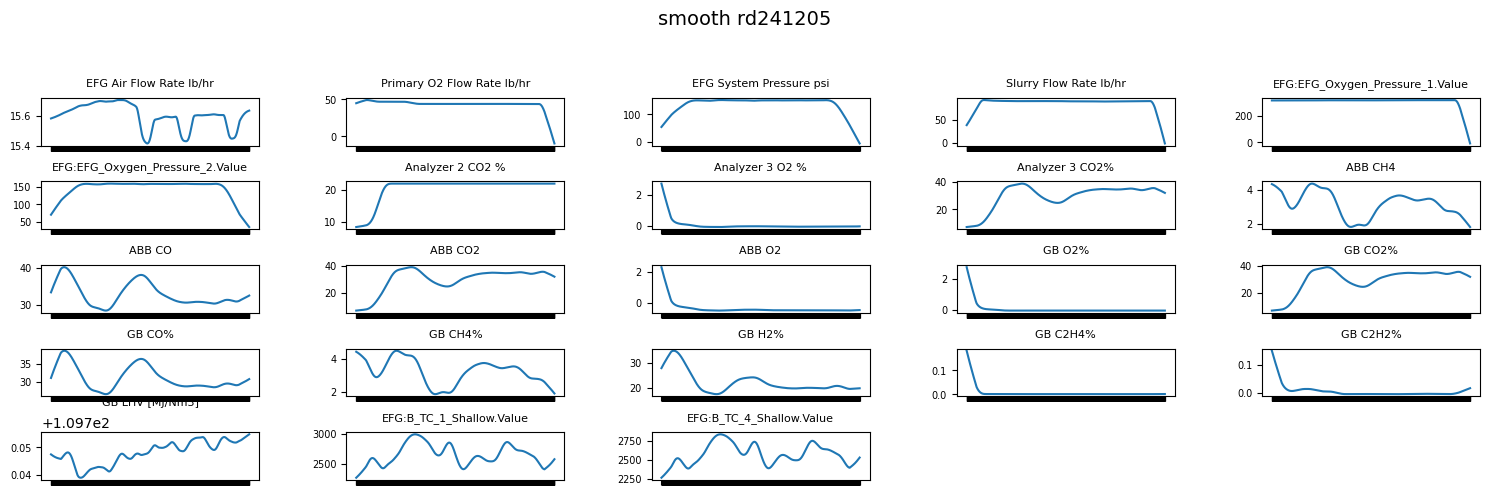

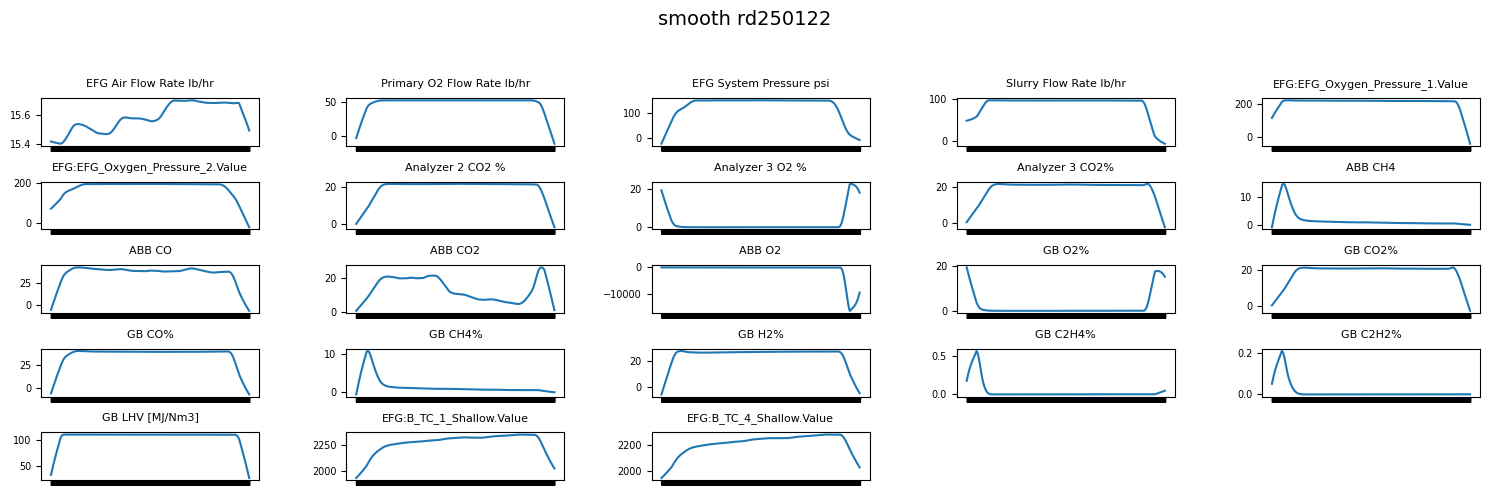

In [10]:
titles = ['smooth rd241203', 'smooth rd241205', 'smooth rd250122']
i = 0
for sdf in smoothed_dfs:
    title = titles[i]
    plot_all_fields(sdf, title)
    i+=1
    